<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#默认配置" data-toc-modified-id="默认配置-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>默认配置</a></span></li><li><span><a href="#Readout测试" data-toc-modified-id="Readout测试-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Readout测试</a></span><ul class="toc-item"><li><span><a href="#波形生成" data-toc-modified-id="波形生成-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>波形生成</a></span></li><li><span><a href="#系统连接" data-toc-modified-id="系统连接-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>系统连接</a></span></li><li><span><a href="#单次运行" data-toc-modified-id="单次运行-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>单次运行</a></span><ul class="toc-item"><li><span><a href="#原始数据" data-toc-modified-id="原始数据-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>原始数据</a></span></li><li><span><a href="#硬解数据" data-toc-modified-id="硬解数据-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>硬解数据</a></span></li></ul></li><li><span><a href="#长时硬解运行" data-toc-modified-id="长时硬解运行-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>长时硬解运行</a></span><ul class="toc-item"><li><span><a href="#信号生成" data-toc-modified-id="信号生成-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>信号生成</a></span></li><li><span><a href="#设备运行" data-toc-modified-id="设备运行-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>设备运行</a></span></li></ul></li></ul></li><li><span><a href="#Control测试" data-toc-modified-id="Control测试-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Control测试</a></span><ul class="toc-item"><li><span><a href="#波形下载测试" data-toc-modified-id="波形下载测试-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>波形下载测试</a></span><ul class="toc-item"><li><span><a href="#系统连接" data-toc-modified-id="系统连接-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>系统连接</a></span></li><li><span><a href="#原始数据下载" data-toc-modified-id="原始数据下载-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>原始数据下载</a></span></li><li><span><a href="#waveforms类下载" data-toc-modified-id="waveforms类下载-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>waveforms类下载</a></span></li></ul></li></ul></li></ul></div>

# 默认配置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from waveforms import *
from time import time, sleep

from quantum_driver.NS_MCI import Driver

In [2]:
deviceIP = "192.168.1.193"

timelen_control = 100e-6
timelen_readout = 4.096e-6

DArate = 6e9
ADrate = 4e9

# Readout测试

## 波形生成

In [3]:
chnls = 8
cntfreq = 12

freqlist = [[] for i in range(8)]
freqlist[0] = [4550e6 + i*300e6 for i in range(cntfreq)]
#freqlist[0] = [4540e6, 4680e6]
freqlist[1] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[2] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[3] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[4] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[5] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[6] = [4550e6 + i*300e6 for i in range(cntfreq)]
freqlist[7] = [4550e6 + i*300e6 for i in range(cntfreq)]


width = 0.5e-6
wav_readout = [zero() for i in range(8)]
for i in range(chnls):
    for j in range(len(freqlist[i])):
        wav_readout[i] = wav_readout[i] + cos(2*np.pi*freqlist[i][j])*(square(width) >> width)
        # wav_readout[i] = wav_readout[i] + (square(width) >> width/2+1e-6)
    wav_readout[i] = wav_readout[i]/cntfreq
    
DAPointNumber = round(timelen_control*DArate)
ADPointNumber = round(timelen_readout*ADrate)
DAtmspace = np.linspace(0,(DAPointNumber-1)/DArate, DAPointNumber)
ADtmspace = np.linspace(0,(ADPointNumber-1)/ADrate, ADPointNumber)

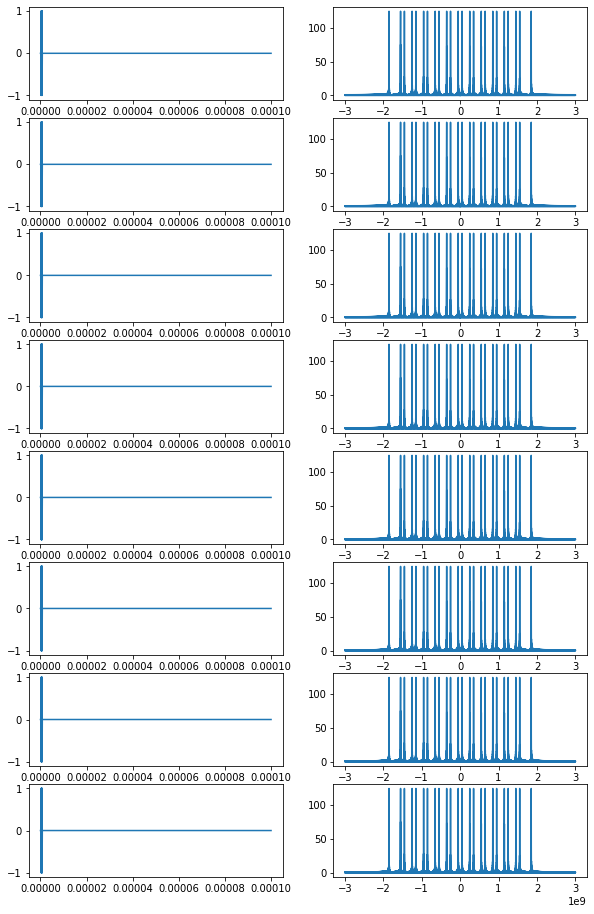

In [4]:
fig,axs = plt.subplots(8,2, figsize=(10,16))
fq = np.fft.fftfreq(DAPointNumber, 1/DArate)
for i in range(8):
    axs[i][0].plot(DAtmspace, wav_readout[i](DAtmspace))
    axs[i][1].plot(fq, np.abs(np.fft.fft(wav_readout[i](DAtmspace))))

## 系统连接

In [32]:
driver = Driver(deviceIP)

sysparam = {
    'MixMode': 2, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0 #, 'DArate': 4e9
}

driver.open(system_parameter=sysparam)

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [33]:
shots = 1024
period = 200e3
driver.set('PointNumber', ADPointNumber)
driver.set('Shot', shots)
driver.set('TriggerDelay', 0e-6, 9)

## 单次运行

In [41]:
dtrace = np.empty(shape=[0,ADPointNumber])
dIQ = np.empty(shape = [0,cntfreq, shots], dtype= complex)
ddIQ = np.empty(shape = [0,cntfreq, shots], dtype= complex)
time_start = time()
for i in range(chnls):
    driver.set('Waveform', (wav_readout[i]*.5)(DAtmspace), i+1)
    driver.set('FrequencyList', freqlist[i], i+1)
    
driver.set('StartCapture')  # 启动指令    
driver.set('GenerateTrig',  period)

time_start = time()
for i in range(chnls):
    dIQ = np.append(dIQ, [np.swapaxes(driver.get('IQ', channel=(i+1)),0,1)], axis=0)
print(f'单次硬解耗时：{time()-time_start}')

# time_start = time()
# for i in range(chnls):
#     ddIQ = np.append(ddIQ, [np.swapaxes(driver.get('CPUIQ', channel=(i+1)),0,1)], axis=0)
# print(f'单次硬解耗时：{time()-time_start}')

for i in range(chnls):
    dtrace = np.append(dtrace, [np.mean(driver.get('TraceIQ', channel=(i+1)), axis=0)], axis=0)

# 单轮时间影响因素：
# 1. freqlist频点数目，决定硬解数量
# 2. shots数量
# 3. waveform深度

TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

In [55]:
driver.get('IQ', channel=1).shape

(0,)

In [31]:
dtrace = np.empty(shape=[0,ADPointNumber])
dIQ = np.empty(shape = [0,cntfreq, shots], dtype= complex)
for i in range(chnls):
    dIQ = np.append(dIQ, [np.swapaxes(driver.get('IQ', channel=(i+1)),0,1)], axis=0)
print(f'单次配置及硬解耗时：{time()-time_start}')

for i in range(chnls):
    dtrace = np.append(dtrace, [np.mean(driver.get('TraceIQ', channel=(i+1)), axis=0)], axis=0)

AxisError: axis2: axis 1 is out of bounds for array of dimension 1

### 原始数据

In [10]:
# 时域波形
%matplotlib notebook
fig,axs = plt.subplots(8,2, figsize=(10,16))
fq = np.fft.fftfreq(ADPointNumber, 1/ADrate)
for i in range(8):
    try:
        axs[i][0].plot(ADtmspace, dtrace[i])
        axs[i][1].plot(fq[0:ADPointNumber//2], np.abs(np.fft.fft(dtrace[i]))[0:ADPointNumber//2])
        # axs[i][1].plot(fq, np.abs(np.fft.fft(dtrace[i])))
    except:
        pass

<IPython.core.display.Javascript object>

### 硬解数据

In [17]:
np.allclose(dIQ, ddIQ)

True

In [15]:
# 硬解波形
showfreq = 0 
%matplotlib notebook
fig,axs = plt.subplots(8,3, figsize=(10,24))
for i in range(8):
    try:
        axs[i][0].plot(np.real(dIQ[i,showfreq,:]),np.imag(dIQ[i,showfreq,:]),'.')
        axs[i][1].plot(20*np.log10(np.abs(dIQ[i,showfreq,:])))
        axs[i][2].plot(np.angle(dIQ[i,showfreq,:], True))
    except:
        pass


<IPython.core.display.Javascript object>

In [16]:
# 硬解波形
showfreq = 0
%matplotlib notebook
fig,axs = plt.subplots(8,3, figsize=(10,24))
for i in range(8):
    try:
        axs[i][0].plot(np.real(ddIQ[i,showfreq,:]),np.imag(ddIQ[i,showfreq,:]),'.')
        axs[i][1].plot(20*np.log10(np.abs(ddIQ[i,showfreq,:])))
        axs[i][2].plot(np.angle(ddIQ[i,showfreq,:], True))
    except:
        pass

<IPython.core.display.Javascript object>

## 长时硬解运行

### 信号生成

In [194]:
def coff_para(t=[],freq=200e6, phase=0):
    coeff_list_I = np.array((cos(2 * np.pi * freq)>>)(t))
    coeff_list_Q = np.array(sin(2 * np.pi * freq)(t))
    return coeff_list_I+1j*coeff_list_Q

def getTraceIQ(y,coff_para=np.asarray([])):
    return  np.abs(y).dot(coff_para.T)/len(y)

SyntaxError: invalid syntax (1694028213.py, line 2)

### 设备运行

In [195]:

shots = 1024
period = 200e3


# driver.set('FrequencyList', freqlist[0], 9)
# for i in range(chnls):
#     driver.set('FrequencyList', freqlist[0], 9)
    
    
# driver.set('PointNumber', ADPointNumber)
driver.set('DemodulationParam', coff_para(ADtmspace, freqlist[0][0]).reshape(1, ADPointNumber), 9)
driver.set('Shot', shots)

远程函数报错: 
<class 'NS_MCI.config.RPCMethodExecuteError'>:Traceback with variables (most recent call last):
  File "/home/digilab/RFSdemo/NS_MCI/config.py", line 116, in wrap
    return func(*args, **kwargs)
      args = (<__main__.RFSKitRPCServer object at 0x7f759fb9a0>, 'DemodulationParam', ['numpy.ndarray', b'\x00\x00\x00\x00\x00\x00\xf0?\x07\\\x143&\xa6\x91<\xf3\xee\x00FG\xc8\xe4?\x0f\xef=\xe4>U\xe8?BS\xa8g\x0b\x06\xc4\xbf^\xe4/\x94$\x9b\xef?.\x05\xa5\x06\xd4H\xeb\xbf\xad.\xf5\xe8N\xb8\xe0?\x07UD\x13\x0eo\xee\xbf\xc4\xe8/7\xef\xc6\xd3\xbf\xf8\xa9\xae\xa6\xe2}\xd8\xbf!\x8d2\xcfk\x90\xed\xbf\x82\xddD+.\x0e\xdd?\x94,=\x1d \x83\xec\xbf\xc0\x1b\xf7\x85\xa7\x1d\xef?\xf7\xfc\x94\xa5\x89\xe1\xcd\xbf\xc6\xf4\x97\x9bw\xe3\xe9?\xf4Yu\x04#\xcf\xe2?\x9a\x9392\xe5\x15\xb4?\xa1`&.\xbf\xe6\xef?[;\x7ff\x9e\xa0\xe6\xbf\x1c<\x7ff\x9e\xa0\xe6?\xb1`&.\xbf\xe6\xef\xbf\x13\x8b92\xe5\x15\xb4\xbf\xd1Zu\x04#\xcf\xe2\xbfq\xf4\x97\x9bw\xe3\xe9\xbf\xc8\xf9\x94\xa5\x89\xe1\xcd?\x00\x1c\xf7\x85\xa7\x1d\xef\xbf5,=\x

In [147]:

rounds = 20

dIQ = np.empty(shape = [0,cntfreq], dtype= complex)
dataIQ = np.empty(shape = [0, chnls, cntfreq], dtype = complex)
cnt = 1

time_start = time()

gap = 200e-9


wav_t1 = []
for i in range(rounds):
    wav_t1.append(wav_readout[0] >> i * gap)

channel_data = []
while cnt<=rounds:
    
    _wav = wav_t1[cnt-1]
    
    driver.set('TriggerDelay', 0e-6 + (cnt-1)*gap, 9)

    ### 配置波形 与硬解系数
    #for i in range(chnls):
        #driver.set('Waveform', wav_t(DAtmspace), i+1)
        #driver.set('FrequencyList', freqlist[i], i+1)

    driver.set('Waveform', _wav(DAtmspace), 9)
    ### 启动
    driver.set('StartCapture')  # 启动指令    
    driver.set('GenerateTrig',  period)
    ### 获取硬解结果
    dIQ = np.empty(shape = [0,cntfreq], dtype= complex)
    for i in range(chnls):
        tmp = np.mean(driver.get('IQ', channel=(i+1)), axis=0)
        dIQ = np.append(dIQ, [tmp], axis=0)
    channel_data.append(driver.get('TraceIQ', channel=1))

    dataIQ = np.append(dataIQ, [dIQ], axis=0) 
    # # 测试
    # if cnt==1:
    #     tmp0 = np.mean(driver.get('TraceIQ', channel= 1),axis=0)
    
    if cnt%10==0:
        print(f'当前运行{time()-time_start:.0f}s，{cnt}轮')
    cnt += 1



当前运行49s，10轮
当前运行87s，20轮


In [134]:
len(channel_data)

1

In [148]:
%matplotlib notebook

middle_round = 10


plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(DAtmspace, wav_t1[0](DAtmspace),alpha = 0.4)
plt.plot(DAtmspace, wav_t1[-1](DAtmspace),alpha = 0.4)
plt.plot(DAtmspace, wav_t1[middle_round](DAtmspace),alpha = 0.4)
plt.show()

plt.subplot(212)
plt.plot(np.mean(channel_data[0], axis=0), alpha=0.4)
plt.plot(np.mean(channel_data[middle_round], axis=0), alpha=0.4)
plt.plot(np.mean(channel_data[-1], axis=0), alpha=0.4)
plt.show()

<IPython.core.display.Javascript object>

In [149]:
# 硬解波形
dataIQ = np.rollaxis(dataIQ,0,3)
showfreq = 0 
%matplotlib notebook
fig,axs = plt.subplots(8,3, figsize=(10,24))

for i in range(8):
    try:
        axs[i][0].plot(np.real(dataIQ[i,showfreq,:]),np.imag(dataIQ[i,showfreq,:]),'.')
        axs[i][1].plot(20*np.log10(np.abs(dataIQ[i,showfreq,:])))
        axs[i][2].plot(np.angle(dataIQ[i,showfreq,:], True))
    except:
        pass

<IPython.core.display.Javascript object>

# Control测试

## 波形下载测试

<IPython.core.display.Javascript object>


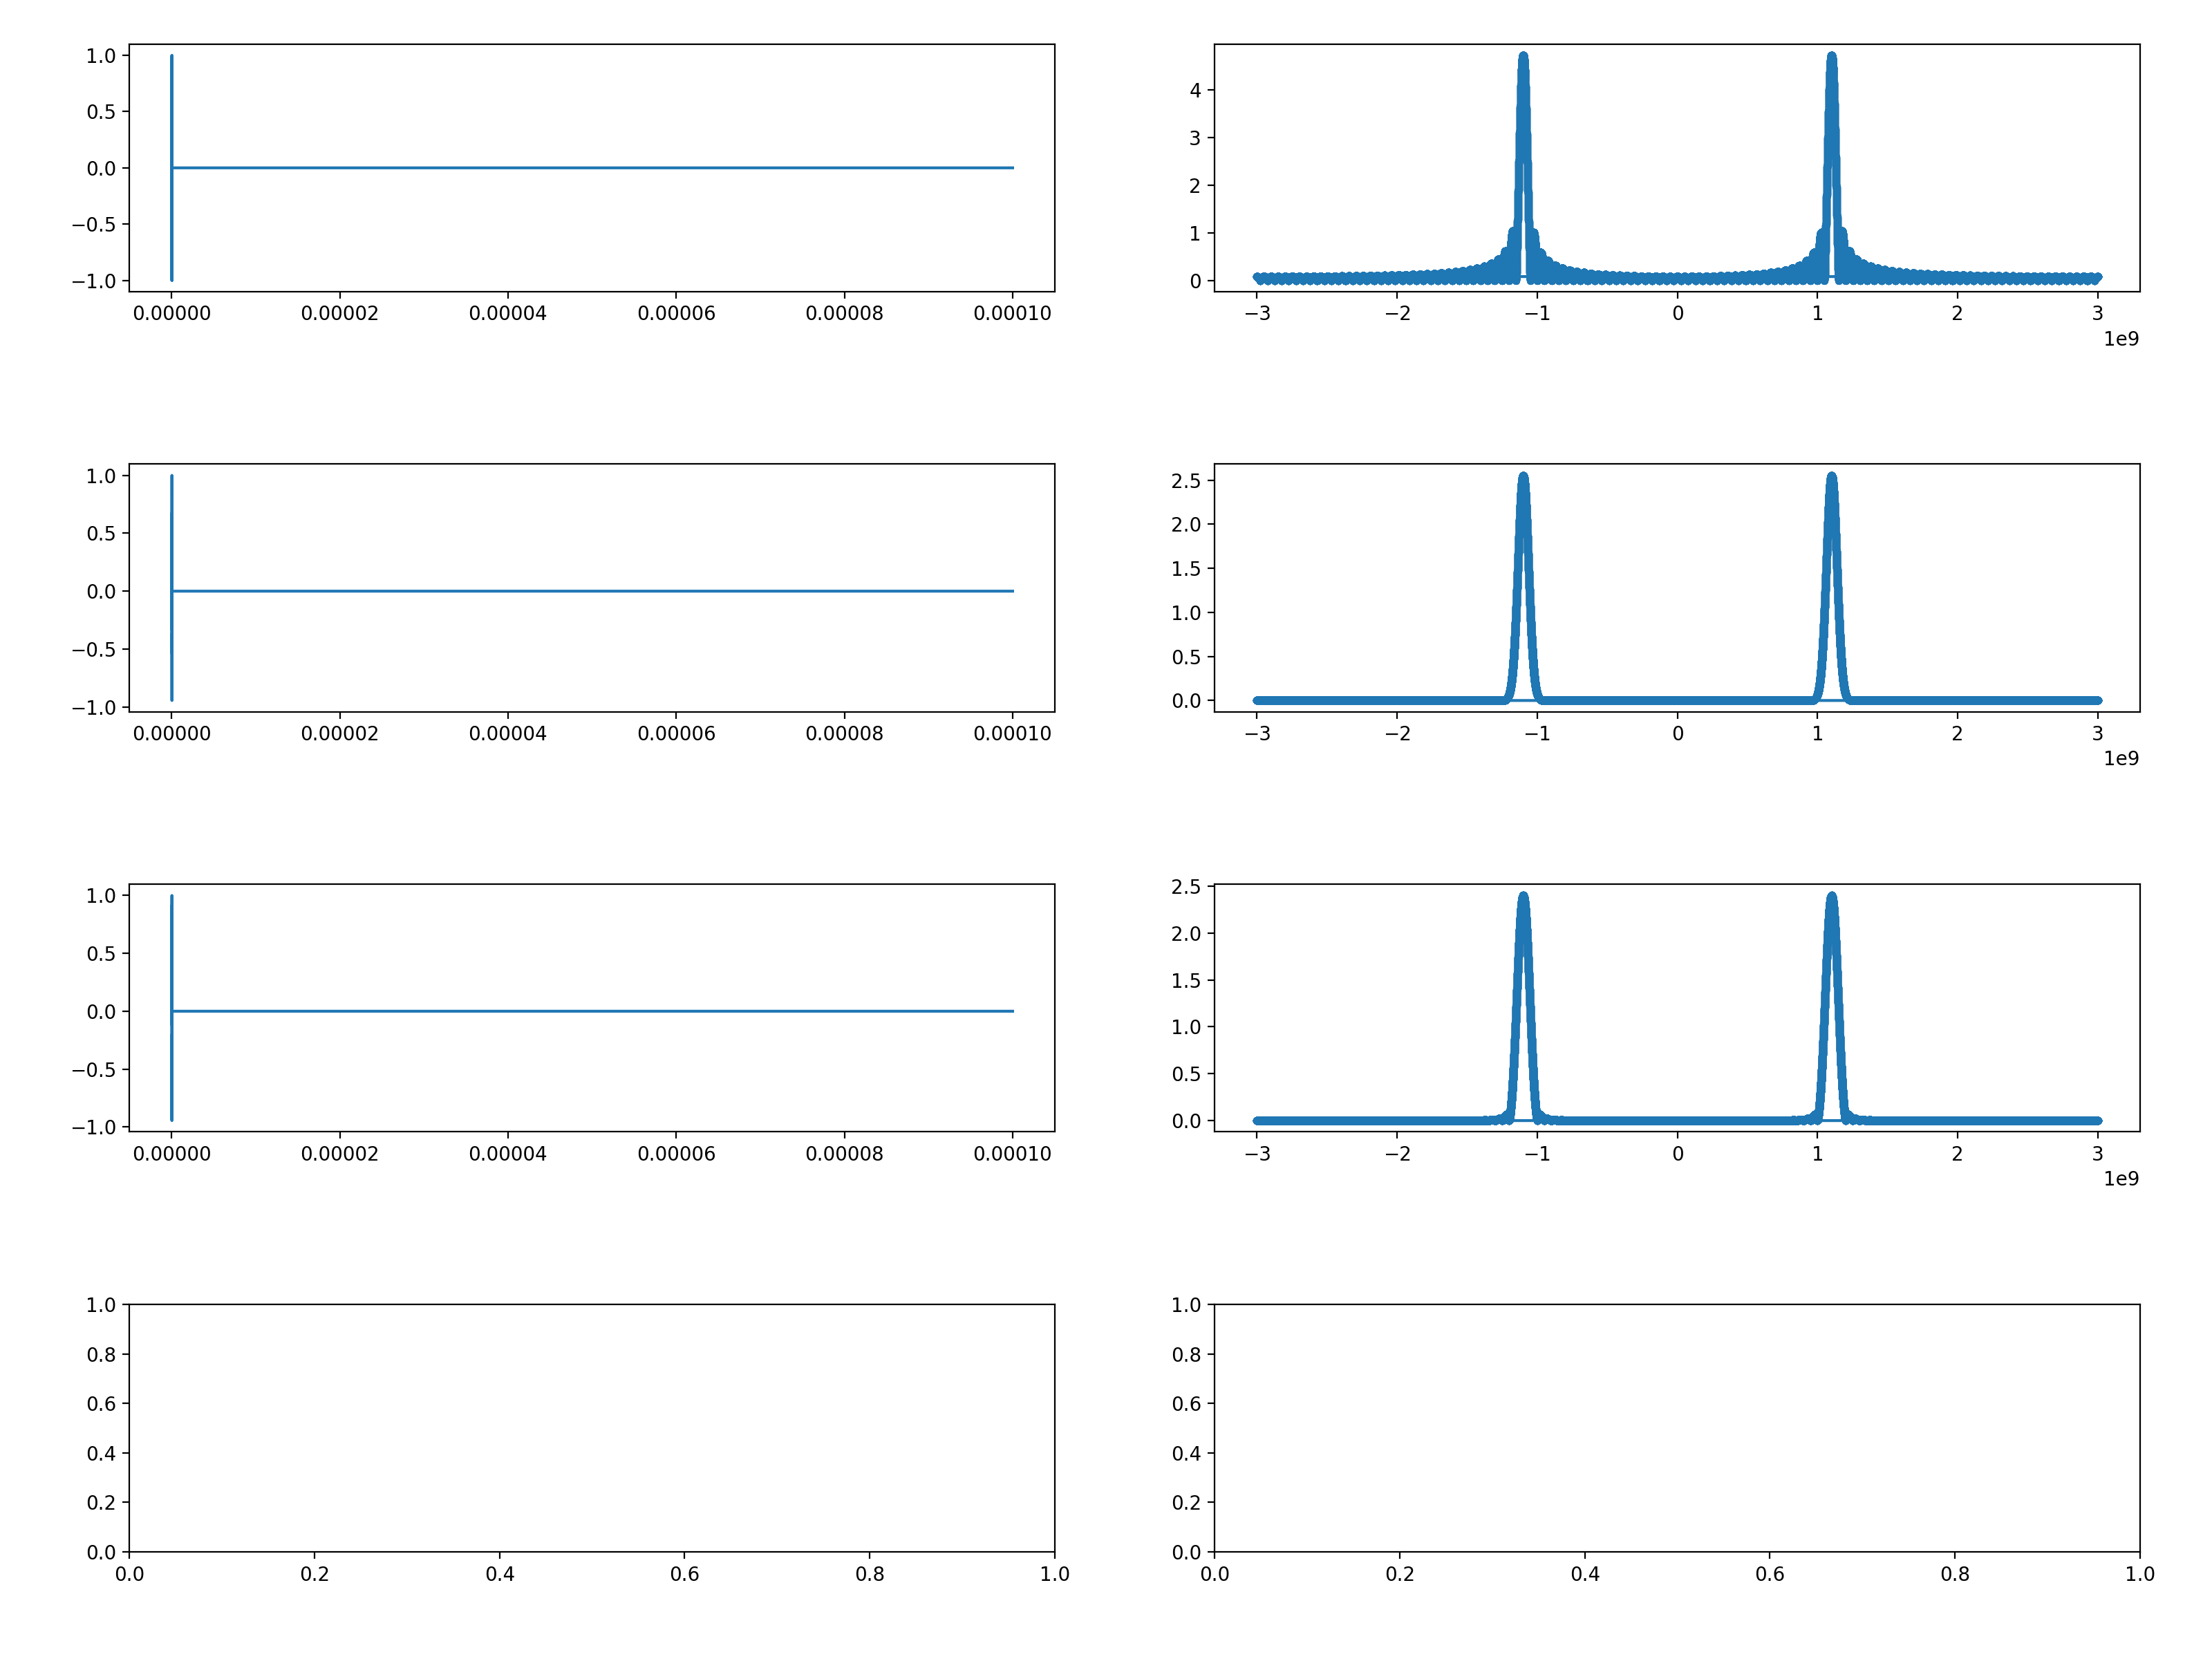

In [12]:
freq = 4.9e9
width = 20e-9


wav1 = (cos(2*np.pi*freq))*(square(width)>>(width*2))
wav2 = (cos(2*np.pi*freq))*(gaussian(width)>>(width*2))
wav3 = (cos(2*np.pi*freq))*(cosPulse(width)>>(width*2))


DAPNC = round(timelen_control*DArate)
tmcontrol = np.linspace(0,(DAPNC-1)/DArate, DAPNC)

fig,axs = plt.subplots(4,2,figsize=(8, 6))
for i in range(3):
    axs[i][0].plot(tmcontrol,eval(f'wav{i+1}(tmcontrol)'))
    fft_freq = np.fft.fftfreq(DAPNC,1/DArate)
    axs[i][1].plot(fft_freq,np.abs(np.fft.fft(np.hamming(DAPNC)*(eval(f'wav{i+1}(tmcontrol)')))),'.-')
fig.tight_layout()

### 系统连接

In [13]:
driver = Driver(deviceIP)

sysparam = {
    'MixMode': 2, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0 #, 'DArate': 4e9
}

driver.open(system_parameter=sysparam)

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


### 原始数据下载

In [28]:
#循环下载
rnd = 5

cnt = 1
time_total = 0
while(cnt<=rnd):
    tstart = time()
    for i in range(8):
        driver.set('Waveform', wav3(tmcontrol), i+1)
    tc = time()-tstart
    print(f'No.{cnt}：{tc:.3f}s')
    cnt += 1
    time_total += tc
print(f'{rnd}次 8通道分别下载 {timelen_control*1e6}us平均时长：{time_total/rnd:.3f}s')

cnt = 1
time_total = 0
while(cnt<=rnd):
    tstart = time()
    driver.set('Waveform', wav3(tmcontrol), 9)
    tc = time()-tstart
    print(f'No.{cnt}：{tc:.3f}s')
    cnt += 1
    time_total += tc
print(f'{rnd}次 8通道共同下载 {timelen_control*1e6}us平均时长：{time_total/rnd:.3f}s （仅适用于相同数据，不常用）')

No.1：0.915s
No.2：0.801s
No.3：0.817s
No.4：0.800s
No.5：0.792s
5次 8通道分别下载 100.0us平均时长：0.825s
No.1：0.390s
No.2：0.431s
No.3：0.435s
No.4：0.440s
No.5：0.436s
5次 8通道共同下载 100.0us平均时长：0.426s （仅适用于相同数据，不常用）


### waveforms类下载

In [33]:
#循环下载
rnd = 5

cnt = 1
time_total = 0
driver.set('LinSpace', (0, (DAPNC-1)/DArate ,DAPNC),9)
while(cnt<=rnd):
    tstart = time()
    for i in range(8):
        driver.set('GenWave', wav3, i+1)
    tc = time()-tstart
    print(f'No.{cnt}：{tc:.3f}s')
    cnt += 1
    time_total += tc
print(f'{rnd}次 8通道 {timelen_control*1e6}us平均时长：{time_total/rnd:.3f}s')

No.1：0.420s
No.2：0.427s
No.3：0.416s
No.4：0.425s
No.5：0.430s
5次 8通道 100.0us平均时长：0.423s
